## Análise de sentimento de tweets de Bolsonaro

Material usado como referência

In [9]:
#https://developer.twitter.com/en/docs/tweets/timelines/api-reference/get-statuses-user_timeline
#http://docs.tweepy.org/en/latest/cursor_tutorial.html#passing-parameters-into-the-api-method
#https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/
#https://medium.com/@viniljf/criando-um-analisador-de-sentimentos-para-tweets-a53bae0c5147
#https://spacy.io/
#https://medium.com/@alegeorgelustosa/an%C3%A1lise-de-sentimentos-e-introdu%C3%A7%C3%A3o-a-nlp-com-python-amazon-yelp-imdb-28a8a66d78cf
#https://towardsdatascience.com/linguistic-complexity-measures-for-text-nlp-e4bf664bd660
#https://py-googletrans.readthedocs.io/en/latest/
#https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

#### Etapas no processamento

<i> Análise dos Tweets</i>

    1 - Minerar dados 
    2 - Criar tabela com dados importantes
    3 - Processar texto
    4 - Plotar popularidade dos Tweets
    5 - Plotagem com da bag of words com a biblioteca wordcloud
    6 - Plotagem de n-gramas
    7 - Análise de quais plataforma são usadas para as postagens

In [10]:
from nltk import word_tokenize
import nltk
import re
import pandas as pd
import tweepy
import time
import json
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

Autentificação

In [11]:
consumer_key= 'rm3PZ9TzVoZxBwoKRNKTnZx6V'
consumer_secret= 'EhhzwZouxE4O5XwHLvGD25vr1aqw9X1lhpnjKNBLdtQEDZOW2F'

access_token='384518822-V5Bh19jOyCHYS5cc5kis7MWX5yjvSkc2XRrIDHNL'
access_token_secret='9QeJGwXsT8upHBfR5RdDTG0xOSlGFxMZlUQgUXlnyNAs4'


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

#### Definindo Funções para minerar tweets

<i>Minera tweets basedos num tema pedido</i>

In [12]:
def miner_tweet(cursor, max_iteration=None):
    it_n = 0
    data = []
    
    while True:
        try:
            tweet = cursor.next()
            mined = {
                'tweet_id':        tweet.id,
                'geo':             tweet.geo,
                'name':            tweet.user.name,
                'screen_name':     tweet.user.screen_name,
                'favourites_count':tweet.user.favourites_count,
                'friends_count':   tweet.user.friends_count,
                'followers_count': tweet.user.followers_count,
                'retweet_count':   tweet.retweet_count,
                'possibly_sensitv':item.possibly_sensitive,
                'text':            tweet.text,
                'mined_at':        datetime.datetime.now(),
                'created_at':      tweet.created_at,
                'favourite_count': tweet.favorite_count,
                'hashtags':        tweet.entities['hashtags'],
                'status_count':    tweet.user.statuses_count,
                'location':        tweet.place,
                'source_device':   tweet.source
                }
            data.append(mined)
            it_n += 1

        except tweepy.TweepError:
            # Devido a limitação a cada 3200 tweets é necessário esperar 15 minutos
            print("wait 15 minutes...")
#             time.sleep(60*15)
            break
        except StopIteration:
            print("Acabou!!")
            break

    return data, it_n

<i>Minera tweets da timeline do perfil solicitado</i>

In [13]:
def miner_timeline(usuario, limite):
#     resultados = api.user_timeline(screen_name=usuario, count=limite, tweet_mode='extended')
    data = [] 
    for item in tweepy.Cursor(api.user_timeline, screen_name=usuario, tweet_mode='extended').items(limite):
        
        mined = {
                        'tweet_id':        item.id,
                        'name':            item.user.name,
                        'screen_name':     item.user.screen_name,
                        'retweet_count':   item.retweet_count,
                        'text':            item.full_text,
                        'mined_at':        datetime.datetime.now(),
                        'created_at':      item.created_at,
                        'favourite_count': item.favorite_count,
                        'hashtags':        item.entities['hashtags'],
                        'status_count':    item.user.statuses_count,
                        'location':        item.place,
                        'source_device':   item.source
                }
        
        try:
            mined['retweet_text'] = item.retweeted_status.full_text
        except:
            mined['retweet_text'] = 'None'
        data.append(mined)
            
        
        
    return data

Minerando tweets do atual presidente e armazenando num DataFrame

In [14]:
tweets_ =miner_timeline(usuario='jairbolsonaro', limite=300)
df_tweetsBol = pd.DataFrame(tweets_)

 Contando quantidade de item presente em cada coluna

In [15]:
df_tweetsBol.count()

created_at         300
favourite_count    300
hashtags           300
location             0
mined_at           300
name               300
retweet_count      300
retweet_text       300
screen_name        300
source_device      300
status_count       300
text               300
tweet_id           300
dtype: int64

In [16]:
df_tweetsBol.describe()

,favourite_count,retweet_count,status_count,tweet_id
count,300.000000,300.000000,300.0,3.000000e+02
mean,24148.190000,4566.976667,8162.0,1.191604e+18
std,23475.253428,4133.436248,0.0,2.965198e+15
min,0.000000,51.000000,8162.0,1.187144e+18
25%,5015.500000,1163.750000,8162.0,1.188910e+18
50%,19014.500000,3666.500000,8162.0,1.191057e+18
75%,35034.250000,6605.750000,8162.0,1.193588e+18
max,169122.000000,29978.000000,8162.0,1.199274e+18


Já que a coluna 'location' não tem nenhum item, iremos retirala

In [17]:
df_tweetsBol = df_tweetsBol.drop('location', axis = 1)

Retirando linhas com texto vazio

In [18]:
df_tweetsBol.head(5)

,created_at,favourite_count,hashtags,mined_at,name,retweet_count,retweet_text,screen_name,source_device,status_count,text,tweet_id
0,2019-11-26 10:30:38,18298,[],2019-11-26 17:59:53.266409,Jair M. Bolsonaro,2746,None,jairbolsonaro,Twitter for Android,8162,- Seguimos tomando iniciativas e criando mecan...,1199274255051046912
1,2019-11-26 10:30:38,32333,[],2019-11-26 17:59:53.266409,Jair M. Bolsonaro,5551,None,jairbolsonaro,Twitter for Android,8162,VIOLÊNCIA SEGUE EM QUEDA\n\n- Dados atualizado...,1199274253146902534
2,2019-11-25 16:04:53,0,[],2019-11-26 17:59:53.266409,Jair M. Bolsonaro,9689,"Crimes caem em todo o país, 22% de assassinato...",jairbolsonaro,Twitter for Android,8162,"RT @SF_Moro: Crimes caem em todo o país, 22% d...",1198995985495711745
3,2019-11-25 12:26:24,22692,[],2019-11-26 17:59:53.266409,Jair M. Bolsonaro,4098,None,jairbolsonaro,Twitter for Android,8162,"- No mais, para enfrentar a esses marginais, é...",1198940999143309313
4,2019-11-25 12:26:23,30806,[],2019-11-26 17:59:53.266409,Jair M. Bolsonaro,6121,None,jairbolsonaro,Twitter for Android,8162,- Quando um governador pede GLO é porque ele n...,1198940997025255426


#### Definindo algumas funções para limpar os dados
***
<i> A  ideia é modificar os processos de tratamento para buscar uma maior acurácia na classificação 

In [19]:
df_tweetsBol['word_count'] = df_tweetsBol['text'].apply(lambda x: len(str(x).split(" ")))

In [20]:
#Baixando a base de dados para o tratamento dos textos
nltk.download('stopwords')
nltk.download('rslp')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Safira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Safira\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Safira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Safira\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
def Lemmatization(instancia):
    palavras = []
    for w in instancia.split():
        palavras.append(wordnet_lemmatizer.lemmatize(w))
    return (" ".join(palavras))

In [22]:
def RemoveStopWords(instancia):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [23]:
def Stemming(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [24]:
def cleanig_data(instancia):
    # remove links, pontos, virgulas,ponto e virgulas dos tweets
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(
        ':','').replace('\n','').replace(')','').replace(',','').replace('@','').replace('@','')
    return (instancia)

In [25]:
def Preprocessing(instancia):
    stemmer = Stemming(instancia)
    cleaned = cleanig_data(stemmer)
    stopwords = RemoveStopWords(cleaned)
    return (stopwords)

In [26]:
import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')


#### Limpando os textos minerados
***

In [27]:
df_tweetsBol['text'] = df_tweetsBol['text'].apply(lambda x: cleanig_data(x))

<i>Contabilizando a quantidade de palavras em cada frase

In [28]:
df_tweetsBol['word_count'] = df_tweetsBol['text'].apply(lambda x: len(str(x).split(" ")))

In [29]:
df_tweetsBol.head(3)

,created_at,favourite_count,hashtags,mined_at,name,retweet_count,retweet_text,screen_name,source_device,status_count,text,tweet_id,word_count
0,2019-11-26 10:30:38,18298,[],2019-11-26 17:59:53.266409,Jair M. Bolsonaro,2746,None,jairbolsonaro,Twitter for Android,8162,seguimos tomando iniciativas e criando mecani...,1199274255051046912,42
1,2019-11-26 10:30:38,32333,[],2019-11-26 17:59:53.266409,Jair M. Bolsonaro,5551,None,jairbolsonaro,Twitter for Android,8162,violência segue em queda dados atualizados apo...,1199274253146902534,32
2,2019-11-25 16:04:53,0,[],2019-11-26 17:59:53.266409,Jair M. Bolsonaro,9689,"Crimes caem em todo o país, 22% de assassinato...",jairbolsonaro,Twitter for Android,8162,rt sf_moro crimes caem em todo o país 22% de a...,1198995985495711745,26


<i> Distribuição da quantidade de palavras contidas nos tweets

[]

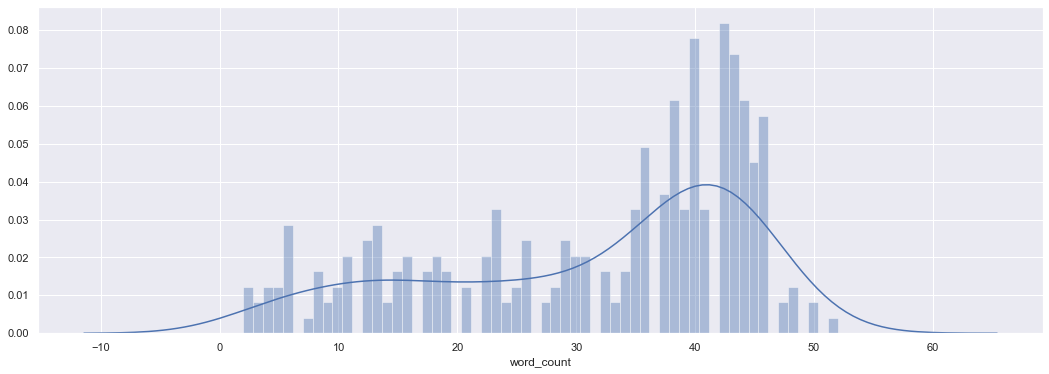

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.figure(figsize=(18,6))
sns.distplot(df_tweetsBol.word_count, bins=60)
plt.plot()

Transformando datas dos tweets para pd.datatime, assim podemos acessar vários atributos específicos

In [31]:
label = pd.DataFrame( ['favourite_count','retweet_count'])

In [32]:
df_tweetsBol['created_at'] = pd.to_datetime(df_tweetsBol.created_at)

C:\Users\Safira\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


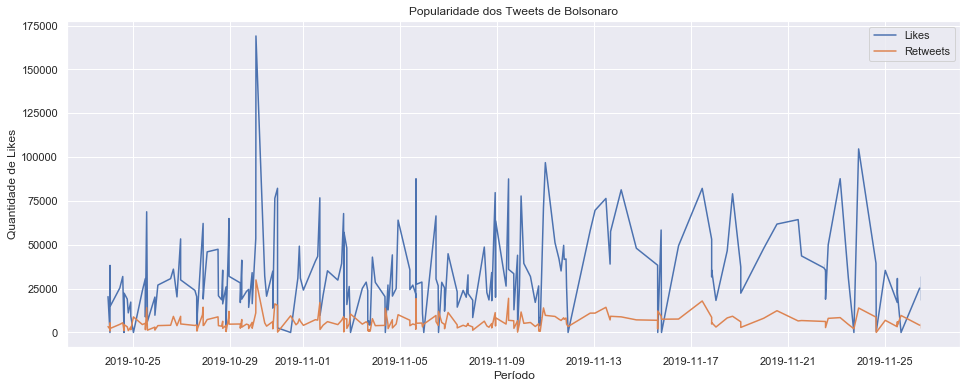

In [33]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x="created_at", y="favourite_count", data=df_tweetsBol,legend='brief', label='Likes' )
ax = sns.lineplot(x="created_at", y="retweet_count", data=df_tweetsBol, legend='brief', label='Retweets' )
ax.set(xlabel='Período', ylabel='Quantidade de Likes')
ax.set_title("Popularidade dos Tweets de Bolsonaro")
plt.show()

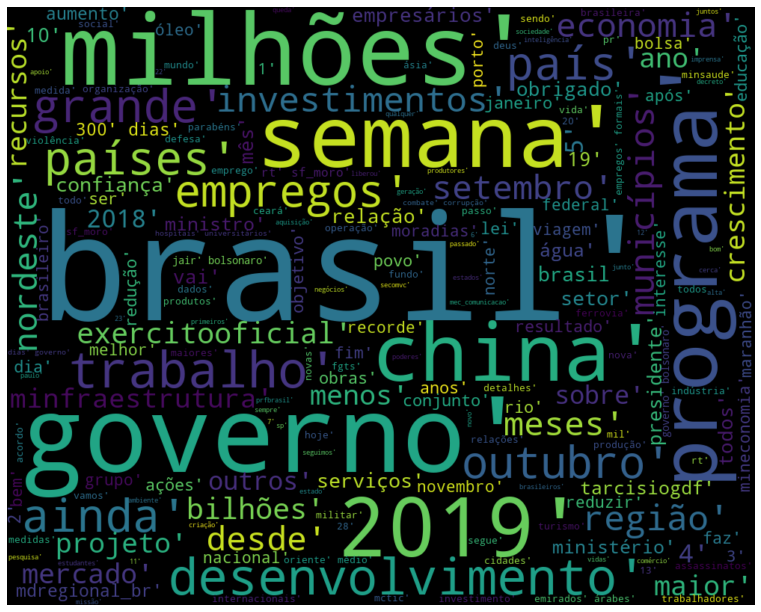

In [34]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

stopword_pt = nltk.corpus.stopwords.words('portuguese')

bag_of_words = []

for i in df_tweetsBol.text:
    removed = RemoveStopWords(i)
    for p in removed.lower().split():
        bag_of_words.append(p)
        
bag_of_words = str(bag_of_words)

wordcloud = WordCloud(width=1000, height=800, margin=0).generate(bag_of_words)
plt.figure(figsize=(20,11))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0,y=0)

As palavras masi frequentes no bag of words apresentam um tamanho maior na representação visual
***

<i> Removendo stopwords e criando algumas funções para gerar os n-grams

In [35]:
df_tweetsBol['No_Stopwords'] = df_tweetsBol['text'].apply(lambda x: RemoveStopWords(x))


In [36]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

#Most frequently occuring Tri-grams
def get_top_n3_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(3,3), 
           max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

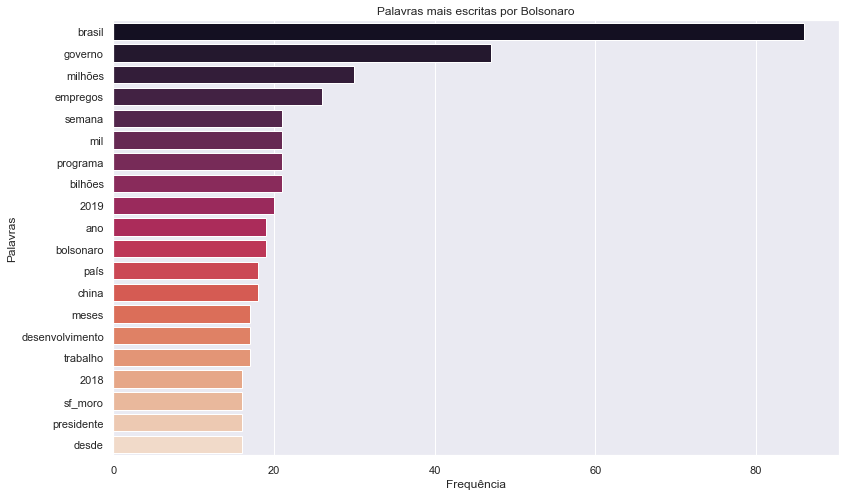

In [37]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(df_tweetsBol['No_Stopwords'] , n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

plt.figure(figsize=(13,8))
ax1 = sns.barplot(y='Word',x='Freq',data=top_df, palette="rocket")
ax1.set(xlabel='Frequência', ylabel='Palavras')
ax1.set_title("Palavras mais escritas por Bolsonaro")
plt.show()

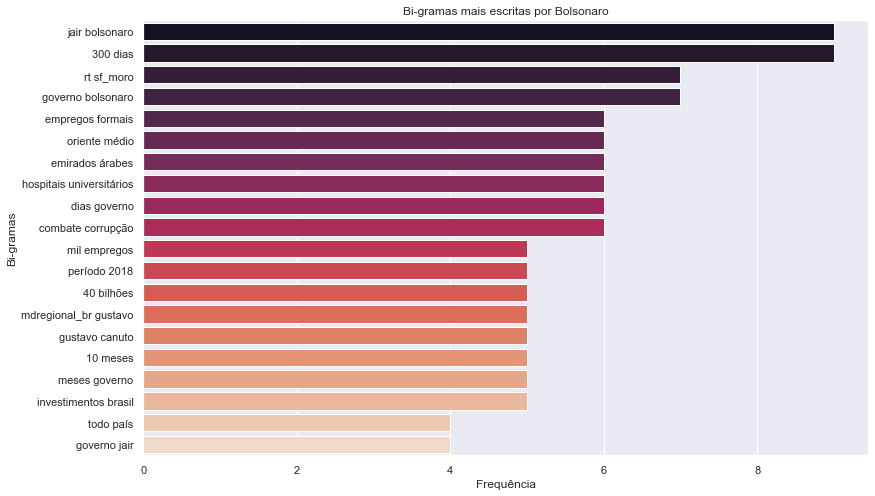

In [38]:
top2_words = get_top_n2_words(df_tweetsBol['No_Stopwords'], n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(y="Bi-gram", x="Freq", data=top2_df, palette="rocket")
h.set(xlabel='Frequência', ylabel='Bi-gramas')
h.set_title("Bi-gramas mais escritas por Bolsonaro")
plt.show()

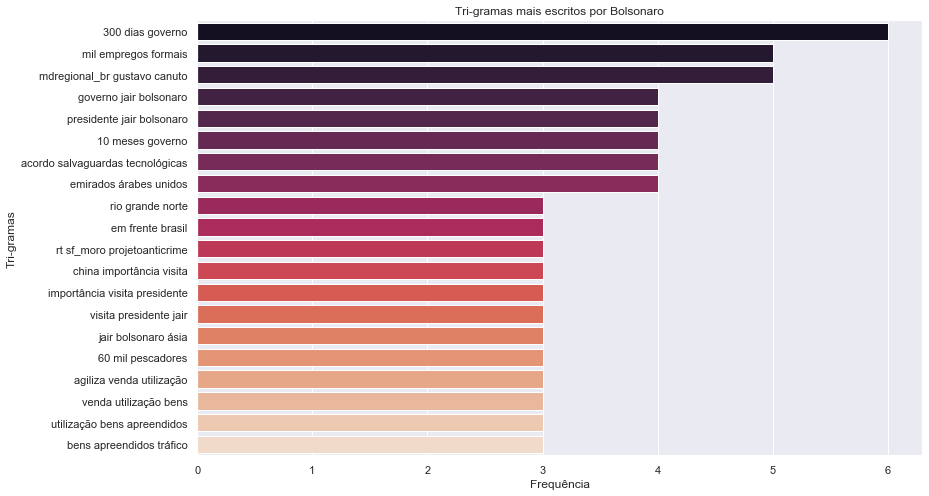

In [39]:
top3_words = get_top_n3_words(df_tweetsBol['No_Stopwords'], n=20)
top3_df = pd.DataFrame(top3_words)
top3_df.columns=["Tri-gram", "Freq"]
#Barplot of most freq Tri-grams
sns.set(rc={'figure.figsize':(13,8)})
j=sns.barplot(y="Tri-gram", x="Freq", data=top3_df, palette="rocket")
j.set(xlabel='Frequência', ylabel='Tri-gramas')
j.set_title("Tri-gramas mais escritos por Bolsonaro")
plt.show()

In [40]:
l_tweetst = df_tweetsBol.nlargest(10, ['favourite_count'])['favourite_count']
l_tweetsn = df_tweetsBol.nlargest(10, ['favourite_count'])['text']

df_tweetst = pd.DataFrame(columns=['Likes', 'Tweet'])
df_tweetst['Likes'] = l_tweetst
df_tweetst['Tweet'] = l_tweetsn

Publicações mais curtidas

In [41]:
df_tweetst

,Likes,Tweet
210,169122,canalhas!
9,104705,parabéns flamengo campeão da copa libertadore...
52,96879,grande dia 🇧🇷👍🏼!
12,87709,com profundo pesar presto solidariedade à fam...
126,87676,300 dias de governo queda recorde de homicídio...
95,87586,amantes da liberdade e do bem somos a maioria ...
203,82243,riscobrasil chega a seu menor patamar desde 20...
30,82202,luis ernesto lacombe exglobo fala do governo ...
38,81374,primeirasdamas do brasil e áfrica do sul boa ...
99,79764,globo news nos cita como expresidente! muitos ...


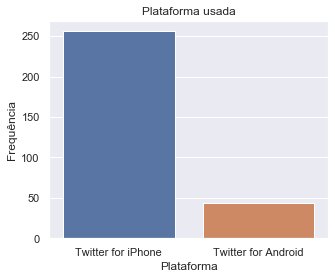

In [42]:
df = pd.DataFrame(df_tweetsBol['source_device'].value_counts())
plt.figure(figsize=(5,4))
ax2 = sns.barplot(x=df.index, y=df['source_device'])
ax2.set(xlabel='Plataforma', ylabel='Frequência')
ax2.set_title("Plataforma usada")
plt.show()

In [43]:
import numpy as np
listrows = np.where(df_tweetsBol['text'].apply(lambda x: x == '' or x == ' ' or x == '  '))
df_tweetsBol = df_tweetsBol.drop(df_tweetsBol.index[listrows])

In [45]:
import spacy
from spacy import displacy
nlp = spacy.load('pt_core_news_sm')

<i> Usando biblioteca spacy para analisar as classes das palavras e as relações entre si

In [47]:
doc = nlp(cleanig_data(df_tweetsBol.loc[26,'text']))
for token in doc:
    print(f'{token.text:{10}} {token.pos:{10}} {token.tag_:{5}} {spacy.explain(token.tag_)} ')

                  103 _SP   None 
semana             92 <np-def>|N|F|S|@NPHR None 
do                 86 ADV|@<ADVL None 
presidente         92 <np-idf>|N|M|S|@N<PRED None 
de                 85 PRP|@N< None 
11                 93 NUM|M|S|@P< None 
a                  85 PRP|@P< None 
17                 93 NUM|M|P|@P< None 
de                 85 PRP|@A< None 
novembro/19         96 PROP|M|S|@P< None 


In [48]:
displacy.render(doc, style='dep',jupyter=True,options={'distance':120})

#### Classificação das frases usando Textblob

In [50]:
from textblob import TextBlob

In [51]:
df_tweetsBol.iloc[288,10] = deEmojify(df_tweetsBol.iloc[288,10])

<i> Para verificarmos a polaridade e subjetividade das frases, temos que traduzilas para o inlglês 

In [52]:
from googletrans import Translator
translator = Translator()

def classifica_sent(frase):
    
    cleaned = remove_emoji(cleanig_data(frase))
    translated = translator.translate(str(cleaned), dest='en',src='pt')
    text = TextBlob(translated.text)
    poli, sub = text.sentiment
    return poli, sub

<i>-POLARITY - é um valor contínuo que varia de -1.0 a 1.0, sendo -1.0 referente a 100% negativo e 1.0 a 100% positivo.

<i>-SUBJECTIVITY - que também é um valor contínuo que varia de 0.0 a 1.0, sendo 0.0 referente a 100% objetivo e 1.0 a 100% subjetivo.

In [53]:
i=0
polarity = []
subjectivity = []

for index, row in df_tweetsBol.iterrows():
    sent, subj = classifica_sent(row['text'])
    polarity.append(sent)
    subjectivity.append(subj)
    i+=1
    
df_tweetsBol['POLARITY'] = polarity
df_tweetsBol['SUBJECTIVITY'] = subjectivity

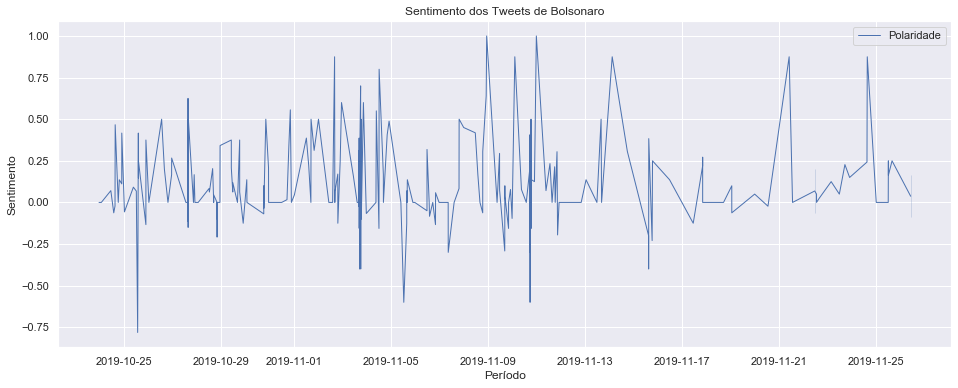

In [58]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x="created_at", y="POLARITY", data=df_tweetsBol,legend='brief', label='Polaridade', lw=1 )
# ax = sns.lineplot(x="created_at", y="SUBJECTIVITY", data=df_tweetsBol, legend='brief', label='Subjetividade' )
ax.set(xlabel='Período', ylabel='Sentimento')
ax.set_title("Sentimento dos Tweets de Bolsonaro")
plt.show()

In [55]:
a = -1 + (2/3)
b = a + (2/3)
sentiment = []

for pol in df_tweetsBol.POLARITY:
    if pol >= b:
        sentiment.append('positive')
    elif pol <= a:
        sentiment.append('negative')
    else:
        sentiment.append('neutro')

    
df_tweetsBol['Sentiment'] = sentiment

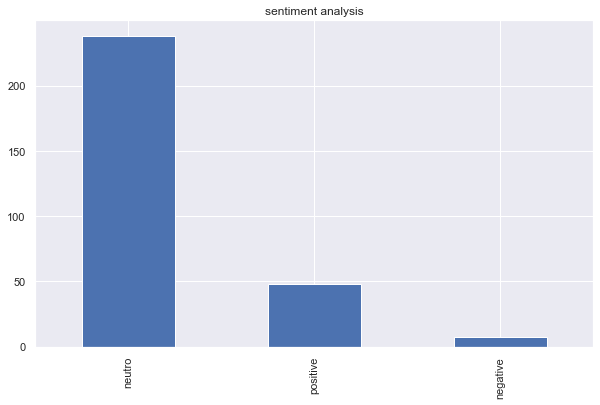

In [56]:
plt.figure(figsize = (10,6))
df_tweetsBol.Sentiment.value_counts().plot(kind='bar',title="sentiment analysis")
plt.show()

Gráfico de barras dos perfis de cada classificação
***

Scatler Plot relacionando duas features, para verificar se existe alguma correlação.

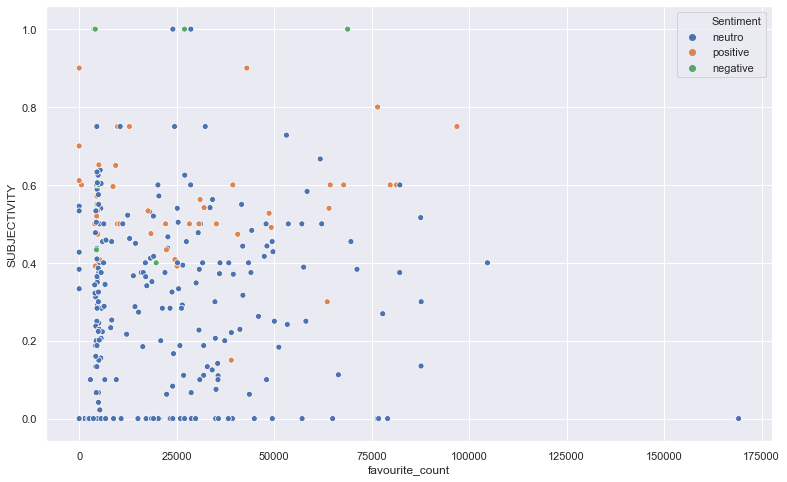

In [57]:
 ax = sns.scatterplot(x="favourite_count", y="SUBJECTIVITY", hue='Sentiment',data=df_tweetsBol)

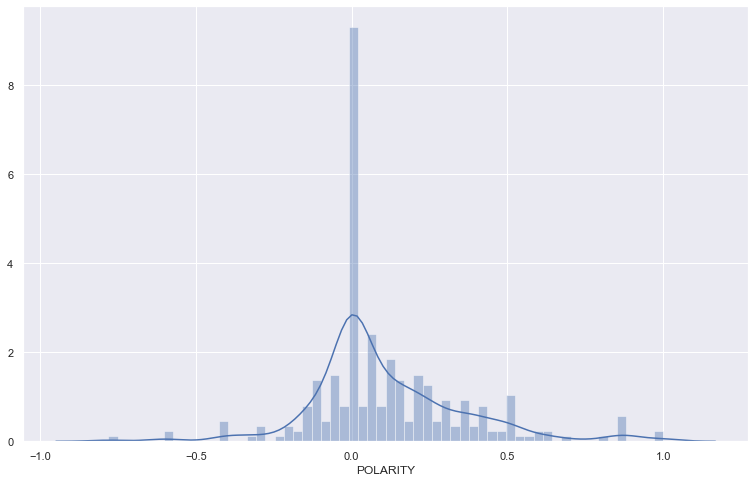

In [60]:
sns.distplot(df_tweetsBol.POLARITY , bins=60)